In [1]:
# Imports
import re
import pathlib
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from cycler import cycler
# plt.rcParams["axes.prop_cycle"] = cycler(color='bgrcmyk')

# Define some useful function

def load_data(results_file, check_error=True):
    """Load and preprocess data"""
    df = pd.read_csv(results_file, sep="\t")
    # Separate out benchmark command
    warp_command = df.iloc[-1].idx
    df = df.iloc[:-1]
    # Drop some unused columns
    df = df.drop(['idx'], axis=1)
    if check_error:
        if df.error.isna().all():
            df = df.drop('error', axis=1)
        else:
            raise Exception("Errors found in df.error column")
    if df.n_objects.eq(1).all():
        df = df.drop('n_objects', axis=1)
    return df, warp_command

def load_summary(filename):
    df = pd.read_csv(filename, sep="\t")
    df = df[~(df.op == "op")]
    for col in ['mb_per_sec', 'objs_per_sec']:
        df[col] = pd.to_numeric(df[col])
    return df

def parse_text_summary(filename):
    """Parses the text summary from `warp analyze ...` and generates a dict of throughput values"""
    # Read input and compile reusable regexs
    op_regex = re.compile(r"[A-Z][A-Z]+")
    score_regex = re.compile(r"[0-9]+\.[0-9]+\ [a-zA-Z]+/s")
    with open(filename, "r") as file:
        lines = file.readlines()
    # Iterate through file lines and extract relevant pieces
    scores = {}
    current_op = None
    for line in lines:
        if line.startswith("Operation: "):
            op = op_regex.search(line)[0]
            current_op = op
            scores[op] = {}
        elif line.startswith(" * Throughput: "):
            for score in score_regex.finditer(line):
                val, units = score[0].split(" ")
                unit_type = units.split("/")[0]
                scores[current_op][unit_type + "_per_sec"] = float(val)
        elif line.startswith("Cluster Total: "):
            scores["Total"] = {}
            for score in score_regex.finditer(line):
                val, units = score[0].split(" ")
                unit_type = units.split("/")[0]
                scores["Total"][unit_type + "_per_sec"] = float(val)

    return scores

def make_bins(df, N_bins):
    """Selects bin edges for data based on log scale and"""
    data = df.bytes[df.op == "PUT"] / 1024**2
    min_size = round(data.min(), ndigits=4)
    max_size = round(data.max())
    return 10**np.linspace(np.log10(min_size), np.log10(max_size), N_bins+1)

def make_filesize_histogram(df, ax, N_bins=10):
    """Plots a histogram showing the distribution of file sizes in the benchmark data"""
    bins = make_bins(df, N_bins)
    data = df.bytes[df.op == "PUT"] / 1024**2
    ax.hist(data, bins=bins, histtype="bar", ec="black")
    ax.set_title("Distribution of randomized file sizes in benchmark data")
    ax.set_xlabel("File size (MiB)")
    ax.set_ylabel("File count")
    ax.set_xscale('log')
    return ax

def make_timings_plot(df, ax, op, N_bins=20):
    
    """Plots file size vs operation time info for benchmark data"""
    
    allowed_ops = df.op.unique()
    if op not in allowed_ops:
        raise Exception("op must be one of", allowed_ops)
    
    bins = make_bins(df, N_bins)
    df = df[df.op == op].copy()
    df['bytes_bin'] = np.digitize(df.bytes / 1024**2, bins)

    data = df.drop('thread', axis=1).groupby('bytes_bin').mean(numeric_only=True)
    ax.plot(data.bytes / 1024**2, data.duration_ns * 1e-9)
    ax.scatter(data.bytes / 1024**2, data.duration_ns * 1e-9, label="Avg")

    data = df.drop('thread', axis=1).groupby('bytes_bin').min(numeric_only=True)
    ax.plot(data.bytes / 1024**2, data.duration_ns * 1e-9)
    ax.scatter(data.bytes / 1024**2, data.duration_ns * 1e-9, label="Min")

    data = df.drop('thread', axis=1).groupby('bytes_bin').max(numeric_only=True)
    ax.plot(data.bytes / 1024**2, data.duration_ns * 1e-9)
    ax.scatter(data.bytes / 1024**2, data.duration_ns * 1e-9, label="Max")

    ax.set_title(f"Reponse times for {op} operations")
    ax.set_xlabel('File size (MiB)')
    ax.set_xscale('log')
    ax.set_ylabel('Operation time (secs)')
    ax.set_yscale('log')
    ax.legend()
    

def plot_grouped_bars(scores, unit, ax=None, op_colours=None):
    groups = list(scores.keys())
    ops = [k for k, v in scores[groups[0]].items() if unit in v.keys()]
    data = {op:[scores[g][op][unit] for g in groups] for op in ops}

    x = np.arange(len(groups))  # the label locations
    width = 1 / (1+len(ops)) # the width of the bars
    # multiplier = -1
    multiplier = (1.5 - len(ops)/2)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    ax.grid(axis="y", lw=0.5, zorder=0)
    
    for i, (op, score) in enumerate(data.items()):
        offset = width * multiplier
        rects = ax.bar(
            x + offset, 
            score, 
            width, 
            ec="k", 
            label=op, 
            zorder=3,
            color=(op_colours[op] if op_colours is not None else None)
        )
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(unit.replace("_per_sec", "/s"))
    ax.set_xticks(x + width, groups)
    ax.legend(ncols=3, title="Operation:")
    
    return ax

In [2]:
df, cmd = load_data("benchmark-runs/warp-results-full.mixed-2-50-1000-1KiB-5GiB-30m.csv.zst")
df

/var/folders/q4/76wx8f413nb6_5zh09x8312r0000gn/T/ipykernel_53690/2356893658.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results_file, sep="\t")


,thread,op,client_id,bytes,endpoint,file,start,first_byte,end,duration_ns
0,91.0,GET,F0d1Ih,17200.0,http://172.26.70.68,nKsIc0ez/3.L1RW8Hmiz7fB25cZ.rnd,2023-03-02T21:14:44.405961821Z,2023-03-02T21:14:44.407989903Z,2023-03-02T21:14:44.408009183Z,2047362.0
1,67.0,DELETE,F0d1Ih,0.0,http://172.26.70.68,ZwNbCC3x/2.Llqv)TTbc3cFOfbL.rnd,2023-03-02T21:14:44.405966061Z,NaN,2023-03-02T21:14:44.407418967Z,1452906.0
2,22.0,DELETE,VRH9cY,0.0,http://172.26.70.68,xCwlYo5U/10.02QAKWhdE0doLdpU.rnd,2023-03-02T21:14:44.40597771Z,NaN,2023-03-02T21:14:44.408264131Z,2286421.0
3,71.0,GET,F0d1Ih,27519525.0,http://172.26.70.68,Du8UMUAe/4.9N4)vmo2MkOhv0Hr.rnd,2023-03-02T21:14:44.405986991Z,2023-03-02T21:14:44.413863086Z,2023-03-02T21:14:44.853696945Z,447709954.0
4,15.0,STAT,VRH9cY,0.0,http://172.26.70.68,ub3rbUsb/4.tEPqvce0McJfURLO.rnd,2023-03-02T21:14:44.40599074Z,NaN,2023-03-02T21:14:44.408439694Z,2448954.0
...,...,...,...,...,...,...,...,...,...,...
81782,33.0,STAT,VRH9cY,0.0,http://172.26.70.68,l((fo9wu/51.X7r17xYhzwchvGT7.rnd,2023-03-02T21:44:44.378177226Z,NaN,2023-03-02T21:44:44.379033621Z,856395.0
81783,33.0,STAT,VRH9cY,0.0,http://172.26.70.68,qq8(klTA/60.3hXSgJVmVcsRcaAO.rnd,2023-03-02T21:44:44.379043431Z,NaN,2023-03-02T21:44:44.379787724Z,744293.0
81784,33.0,GET,VRH9cY,12552.0,http://172.26.70.68,clM8dtQx/123.2hCLnPV2E7kqS2vg.rnd,2023-03-02T21:44:44.379796434Z,2023-03-02T21:44:44.38127844Z,2023-03-02T21:44:44.381290241Z,1493807.0
81785,33.0,STAT,VRH9cY,0.0,http://172.26.70.68,73E5gPAd/44.4f84qVuBnZ(NDpoN.rnd,2023-03-02T21:44:44.381296481Z,NaN,2023-03-02T21:44:44.38237451Z,1078029.0


/var/folders/q4/76wx8f413nb6_5zh09x8312r0000gn/T/ipykernel_52787/3200979117.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results_file, sep="\t")


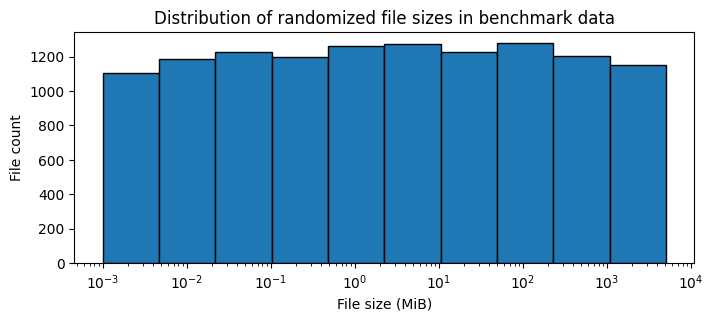

In [5]:
df, cmd = load_data("benchmark-runs/warp-results-full.mixed-2-50-1000-1KiB-5GiB-30m.csv.zst")
fig, ax = plt.subplots(figsize=(8, 3))
make_filesize_histogram(df, ax)
plt.show()

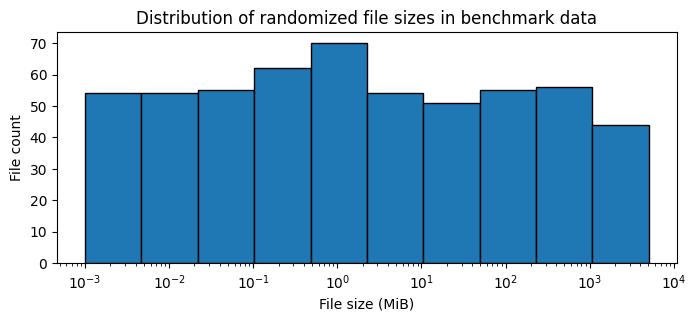

In [8]:
df, cmd = load_data("benchmark-runs/warp-results-full.mixed-1-1-1000-1KiB-5GiB-30m.csv.zst")
fig, ax = plt.subplots(figsize=(8, 3))
make_filesize_histogram(df, ax)
plt.show()

In [14]:
min_bytes = 5*1024
max_bytes = 15*1024
df[(df.bytes >= min_bytes) & (df.bytes <= max_bytes)]

,thread,op,client_id,bytes,endpoint,file,start,first_byte,end,duration_ns
16,59.0,GET,F0d1Ih,6880.0,http://172.26.70.68,K8xMjX(K/1.Xs1IyGXZMx8wddua.rnd,2023-03-02T21:14:44.406228054Z,2023-03-02T21:14:44.409441659Z,2023-03-02T21:14:44.409506669Z,3278615.0
27,13.0,PUT,VRH9cY,14863.0,http://172.26.70.68,l((fo9wu/1.HJdIpd1uGQ(wxQoq.rnd,2023-03-02T21:14:44.406396408Z,NaN,2023-03-02T21:14:44.41498182Z,8585412.0
30,96.0,GET,F0d1Ih,9612.0,http://172.26.70.68,pilt5KBK/3.y7LG)Vf2R0ijVzPf.rnd,2023-03-02T21:14:44.406465537Z,2023-03-02T21:14:44.407925862Z,2023-03-02T21:14:44.407942362Z,1476825.0
85,92.0,GET,F0d1Ih,5803.0,http://172.26.70.68,h6cbZd4h/5.2xPv7uiImVkeTqDv.rnd,2023-03-02T21:14:44.407841411Z,2023-03-02T21:14:44.410974675Z,2023-03-02T21:14:44.410986955Z,3145544.0
102,24.0,PUT,VRH9cY,7973.0,http://172.26.70.68,Yp)Lz5E4/1.oTwEUaaQiR0)q08N.rnd,2023-03-02T21:14:44.408261271Z,NaN,2023-03-02T21:14:44.414885828Z,6624557.0
...,...,...,...,...,...,...,...,...,...,...
81578,41.0,GET,VRH9cY,10295.0,http://172.26.70.68,usbPNGXr/78.Q6VAjInmge(tOzqU.rnd,2023-03-02T21:44:40.291378474Z,2023-03-02T21:44:40.294987698Z,2023-03-02T21:44:40.295003828Z,3625354.0
81725,56.0,GET,F0d1Ih,5521.0,http://172.26.70.68,6IcX2YQZ/53.czbzK6LXugxbeqKX.rnd,2023-03-02T21:44:43.420947844Z,2023-03-02T21:44:43.426561106Z,2023-03-02T21:44:43.426573016Z,5625172.0
81748,33.0,GET,VRH9cY,13447.0,http://172.26.70.68,ha)aQblO/64.zYV3fXcQuKAGhbxJ.rnd,2023-03-02T21:44:43.839975071Z,2023-03-02T21:44:43.841875364Z,2023-03-02T21:44:43.841918295Z,1943224.0
81751,23.0,GET,VRH9cY,7512.0,http://172.26.70.68,iV0RMQIJ/123.8e3(EaYRZSKm1(gq.rnd,2023-03-02T21:44:43.847076556Z,2023-03-02T21:44:43.858281043Z,2023-03-02T21:44:43.858294564Z,11218008.0


In [9]:
# summary_df = load_summary("benchmark-runs/warp-results-summary.mixed-1-1-1000-1KiB-5GiB-30m.csv")
summary_df = load_summary("benchmark-runs/warp-results-summary.mixed-2-50-1000-1KiB-5GiB-30m.csv")
summary_df.mb_per_sec[df.op == "GET"].mean()

1885.1650733950696

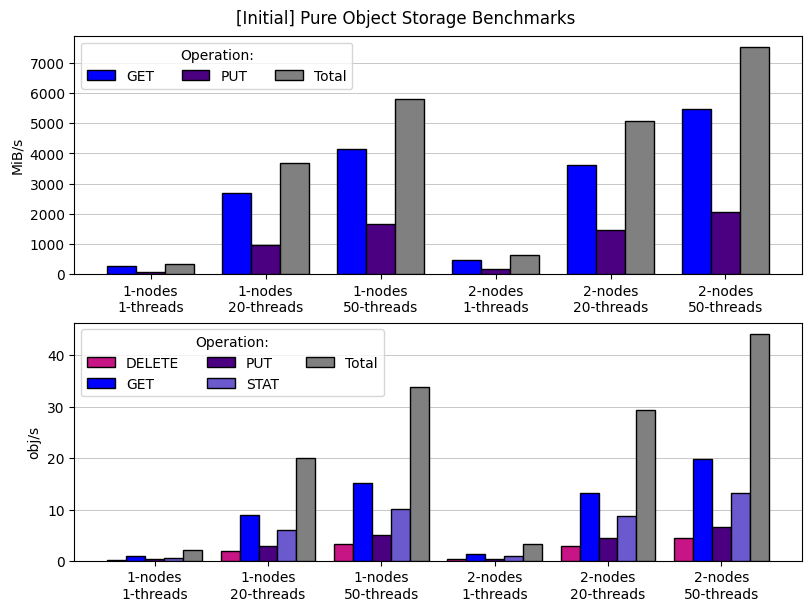

In [71]:
# Code 

scores = {}
for nodes, threads in itertools.product([1, 2], [1, 20, 50]):
    key = f"{nodes}-nodes\n{threads}-threads"
    scores[key] = parse_text_summary(f'benchmark-runs/warp-results-summary.mixed-{nodes}-{threads}-1000-1KiB-5GiB-30m.txt')

op_colours = {"GET":"blue", "PUT":"indigo", "STAT":"slateblue", "DELETE":"mediumvioletred", "Total":"grey"}
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, constrained_layout=True)
plot_grouped_bars(scores, "MiB_per_sec", axs[0], op_colours)
plot_grouped_bars(scores, "obj_per_sec", axs[1], op_colours)
fig.suptitle("[Initial] Pure Object Storage Benchmarks")
plt.savefig("initial-pure-results.png")
plt.show()

/var/folders/q4/76wx8f413nb6_5zh09x8312r0000gn/T/ipykernel_53690/2356893658.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results_file, sep="\t")


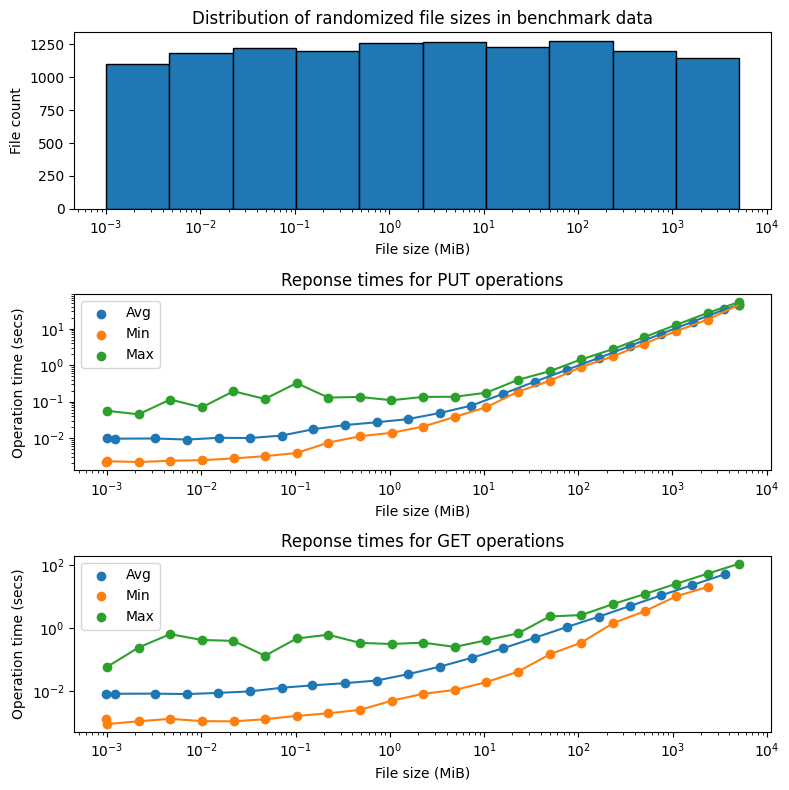

In [4]:
# Create plot 
df, cmd = load_data("benchmark-runs/warp-results-full.mixed-2-50-1000-1KiB-5GiB-30m.csv.zst")
fig, axs = plt.subplots(figsize=(8, 8), nrows=3)
make_filesize_histogram(df, axs[0])
make_timings_plot(df, axs[1], "PUT")
make_timings_plot(df, axs[2], "GET")
plt.tight_layout()
plt.show()

/var/folders/q4/76wx8f413nb6_5zh09x8312r0000gn/T/ipykernel_17718/1618230849.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, group in data.drop(['thread'], axis=1).groupby(['bytes_bucket']):


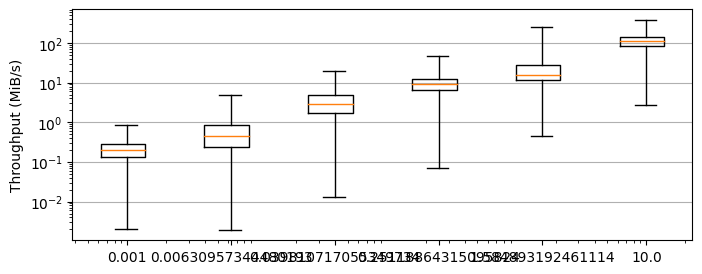

In [241]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.set_xscale('log')
ax.set_ylabel('Throughput (MiB/s)')
ax.set_yscale('log')
ax.grid('on', axis='y')

for i, group in data.drop(['thread'], axis=1).groupby(['bytes_bucket']):
    throughput = (group.bytes / 1024**2) / (group.duration_ns * 1e-9)
    ax.boxplot(throughput, positions=[bins[i]], whis=(0, 100), widths=0.75*bins[i])

# ax.set_xscale('')
# x_labels = data.groupby('bytes_bucket').bytes.max().map(lambda val: round(val / 1024**2, ndigits=3))
# x_labels = data.groupby('bytes_bucket').bytes.max().map(lambda val: f"{val:.3g}")
# ax.set_xticklabels(x_labels, rotation=-45)
plt.show()

In [317]:
df_analyzed = pd.read_csv("results_analyzed.csv", sep="\t")
df_analyzed

,index,op,host,duration_s,objects_per_op,bytes,full_ops,partial_ops,ops_started,ops_ended,errors,mb_per_sec,ops_ended_per_sec,objs_per_sec,reqs_ended_avg_ms,start_time,end_time
0,0,PUT,http://fs-perf-dev-login-0:9000,1,1,348909838,266,39,286,285,0,332.74635124206543,285,289.3893263690584,56.40032255438595,2023-02-15 11:14:42.118062506 +0000 UTC,2023-02-15 11:14:43.118062506 +0000 UTC
1,1,PUT,http://fs-perf-dev-login-0:9000,1,1,402545597,298,40,318,318,0,383.8973970413208,318,313.02223408668135,73.22804761320754,2023-02-15 11:14:43.118062506 +0000 UTC,2023-02-15 11:14:44.118062506 +0000 UTC
2,2,PUT,http://fs-perf-dev-login-0:9000,1,1,352329271,284,40,304,304,0,336.0073766708374,304,310.5934517776044,56.87420175986845,2023-02-15 11:14:44.118062506 +0000 UTC,2023-02-15 11:14:45.118062506 +0000 UTC
3,3,PUT,http://fs-perf-dev-login-0:9000,1,1,266272593,197,40,217,217,0,253.93733310699463,217,209.44104304136007,104.69695640092168,2023-02-15 11:14:45.118062506 +0000 UTC,2023-02-15 11:14:46.118062506 +0000 UTC
4,4,PUT,http://fs-perf-dev-login-0:9000,1,1,383980809,372,40,392,392,0,366.19263553619385,392,393.81238883385896,51.051465545918404,2023-02-15 11:14:46.118062506 +0000 UTC,2023-02-15 11:14:47.118062506 +0000 UTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,114,GET,http://fs-perf-dev-login-0:9000,5,1,3863402612,2915,40,2935,2935,0,736.8855690002441,587,587.4560450344351,33.919761693696685,2023-02-15 11:24:22.095808809 +0000 UTC,2023-02-15 11:24:27.095808809 +0000 UTC
122,115,GET,http://fs-perf-dev-login-0:9000,5,1,4174352419,3464,40,3484,3484,0,796.1945379257202,696.8,694.9325438994845,28.537003970723326,2023-02-15 11:24:27.095808809 +0000 UTC,2023-02-15 11:24:32.095808809 +0000 UTC
123,116,GET,http://fs-perf-dev-login-0:9000,5,1,3740417812,3124,40,3144,3144,0,713.4280799865722,628.8,629.9992608420849,32.09282537945292,2023-02-15 11:24:32.095808809 +0000 UTC,2023-02-15 11:24:37.095808809 +0000 UTC
124,117,GET,http://fs-perf-dev-login-0:9000,5,1,3701756801,3212,40,3232,3232,0,706.0540773391724,646.4,647.1346859307301,30.32831833756182,2023-02-15 11:24:37.095808809 +0000 UTC,2023-02-15 11:24:42.095808809 +0000 UTC
